In [27]:
import torch
from torch import nn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Introduction to Neural Networks

In machine learning, classification tasks are among the most common problems. A classification task consists of assigning a class to a given object. For example, deciding whether a photo shows a dog or a cat, determining whether a biopsy image is cancerous or not, or assigning a category to a web article are all examples of classification problems.  

In general, we can distinguish three main types of classification problems:

1. **Binary classification**: here, the target variable can take only one of two possible values (yes/no, true/false, dog/cat, etc.). These are the simplest classification problems, but also among the most frequent in real-world applications.  
2. **Multi-class classification**: in this case, the target variable can take more than two possible values. For instance, in sentiment analysis, a tweet might be classified as positive, negative, or neutral.  
3. **Multi-label classification**: here, the target can be assigned multiple labels simultaneously. For example, when classifying the themes of a web article, we might assign more than one label, such as *science*, *mathematics*, and so on.  

Classification problems can be solved with traditional machine learning algorithms, such as *Decision Trees*, *Logistic Regression*, or *Naive Bayes*. In this notebook, however, we will focus on more advanced approaches: *Neural Networks*. We will build a simple neural network for classification from scratch using PyTorch, while also briefly discussing the mathematics behind the architecture.  

In particular, we will cover:  
- The typical architecture of a neural network;  
- How to build a neural network model with PyTorch from scratch, including the loss function, the optimizer, and the training loop;  
- How to train the model and make predictions on unseen data;  
- How to improve the model from an architectural perspective.  


## Make classification data

First of all, we need a classification problem! Let's stick to example shown in the *Zero to Mastery* course, i.e we use the `make_circles` function from `sklearn` to generate two circles of different radius:

In [3]:
# Create circles, 
X, y = make_circles(1000, noise = 0.03, random_state = 42)

In [6]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [8]:
X.shape

(1000, 2)

In [7]:
y[:5]

array([1, 1, 1, 1, 0])

In [9]:
y.shape

(1000,)

We see that $X$ is an array of shape (1000, 2), i.e. we have 1000 points with two coordinates, say $X_1, X_2$. In contrast, $y$ is an array of shape (1000,1) with 0, 1 values. Let's make a pandas dataframe from these two arrays and plot the corresponding circle.

In [11]:
# Create a pandas dataframe
df_circles = pd.DataFrame(
    {
        "X_1": X[:,0], 
        "X_2": X[:,1],
        "label": y
    }
)

In [12]:
df_circles

,X_1,X_2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


Text(0, 0.5, '$X_2$')

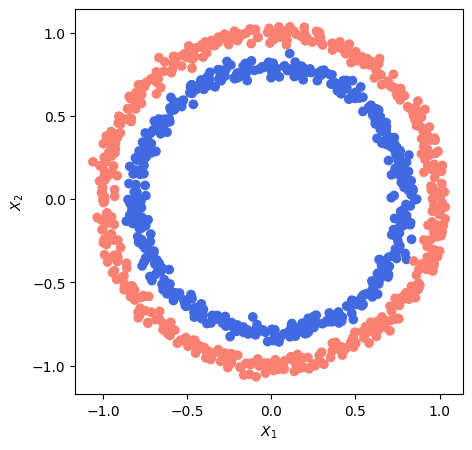

In [21]:
# Plotting the circles:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(df_circles["X_1"], df_circles["X_2"], c=df_circles["label"].map(lambda x: "royalblue" if x == 1 else "salmon"))
ax.set_xlabel(r"$X_1$")
ax.set_ylabel(r"$X_2$")

In [22]:
# Let's check different labels
df_circles["label"].value_counts()

label
1    500
0    500
Name: count, dtype: int64

It looks like we have our classification problem set up: given a pair of coordinates $X_1$ and $X_2$, we need to classify the corresponding point into "red" or "blue", i.e. understanding whether it belongs to the inner or the outer circle. Of course, this is just a **toy dataset**, a dataset that we are using just for testing our model architecture and to make practice. 

### Input and Output Layers

But what is a neural network?  

Informally, we can think of a neural network as a **black box**: it takes some input values and produces some output values. All the complexity of the network lies inside this box, which is nothing more than a sequence of mathematical operations applied to the input.  

The reason it is called *neural* is that its structure was inspired—at least loosely—by how the human brain works. The box is organized into **layers**, often referred to as *hidden layers*. Each layer is made up of units called **neurons**, and each neuron performs a simple mathematical operation on its inputs. By stacking and connecting many neurons across multiple layers, the network can transform raw input data step by step until it produces an output.  

In this sense, a neural network resembles the propagation of a signal in the brain:  
- an **input signal** (the input values) arrives,  
- the **neurons** process this signal through a series of transformations,  
- an **output signal** is produced (in our case, the predicted target variable).  

Below, you can see a diagram that visually represents the structure of a neural network.  

![NN-Architecture](../images/nn-architecture.png)
---

Before we dive into the internal structure (the hidden layers), we first need to understand how to define and represent the **input** and **output layers** in PyTorch.  

A key point to grasp is the **shape** of these layers. Since PyTorch models are built on tensors, most of the common errors you will face come from mismatched tensor shapes during operations. This is, by far, the most frequent beginner mistake—and you will almost certainly run into it yourself. However, by constantly paying attention to the shape of your data and familiarizing yourself with it, you will gradually reduce these errors and become more confident in debugging them.


In [23]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


We see that the shape of a single example of features is $2$, meaning that we have two feature values per record. Hence, a tensor representing the input values will have the second dimension equal to 2. On the other hand, one sample of $y$ has "0 dimensions", meaning that it's a **scalar value**.

Now we need to:
1. Turn out data into *tensors*;
2. Split our data into training and test sets

In [24]:
# Turning data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [25]:
# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [28]:
# Let's use the train_test_split() from sklearn
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2, # 20% test, 80% train
    random_state=42
) # make the random split reproducible

In [30]:
# Checking dimensions
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)